# 런타임 끊김 방지
- F12를 누르고 개발자 콘솔 맨밑 코드입력하는 곳에 아래 JS코드를 입력
```
function ClickConnect(){
  console.log("Connnect Clicked - Start");
  document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
  console.log("Connnect Clicked - End");
};
setInterval(ClickConnect, 60000)
```

# import

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer

import torch

from tqdm.auto import tqdm
from sklearn.metrics import f1_score

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Data/"
SEED = 42

In [ ]:
if not os.path.isdir("image"):
    !cp "{DATA_PATH}open.zip" "open.zip"
    !unzip -qq "open.zip"

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 데이터 분석

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16986 entries, 0 to 16985
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        16986 non-null  object
 1   img_path  16986 non-null  object
 2   overview  16986 non-null  object
 3   cat1      16986 non-null  object
 4   cat2      16986 non-null  object
 5   cat3      16986 non-null  object
dtypes: object(6)
memory usage: 796.3+ KB


## 2) 분류 항목 확인

In [ ]:
train['cat3'].value_counts()

한식                3438
야영장,오토캠핑장         1558
바/까페               785
유적지/사적지            622
일반축제               549
                  ... 
MTB                  2
대중콘서트                2
인라인(실내 인라인 포함)       2
스카이다이빙               2
클래식음악회               2
Name: cat3, Length: 128, dtype: int64

             cat3  count
0             5일장    165
1             ATV      4
2             MTB      2
3               강    104
4          게스트하우스     83
..            ...    ...
123          헬스투어     15
124  헹글라이딩/패러글라이딩      9
125            호수     30
126          홈스테이     57
127        희귀동.식물     88

[128 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49885 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50556 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_

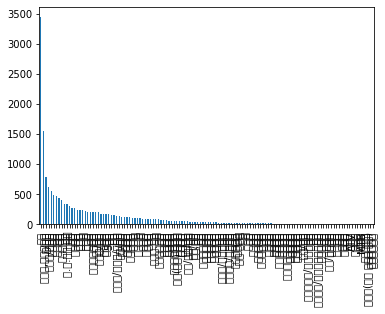

In [ ]:
# 불균형 확인을 위한 시각화
train['cat3'].value_counts().plot(kind = 'bar')
print(train.groupby('cat3').size().reset_index(name = 'count'))

# Overview 길이 분포 및 최솟값, 최댓값 확인

In [ ]:
# 1. overview의 길이로 새로운 columns 생성
train['overview_len'] = train['overview'].apply(lambda x : len(x))

In [ ]:
# 2. overview_len의 최솟값, 최댓값 확인
train['overview_len'].min(), train['overview_len'].max(), train['overview_len'].median()

(7, 7972, 274.0)

In [ ]:
# 3. overview_len의 최솟값 확인
train[train['overview_len'] == 7]['overview'] # 길이가 가장 짧은 overview

3030    홈페이지 참조
Name: overview, dtype: object

In [ ]:
# 4. overview_len의 최댓값 확인
train[train['overview_len'] == 7972]['overview'] # 길이가 가장 긴 overview

1399    우리나라 3대 사찰의 하나로 신라 애장왕 3년(802)에 순응, 이정 두 스님이 창...
Name: overview, dtype: object

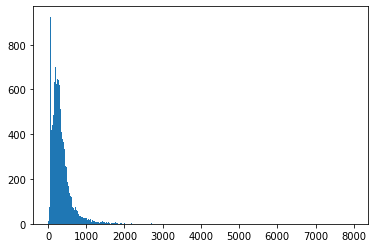

In [ ]:
# 5. overview의 길이 분포 확인
plt.hist(train['overview_len'], bins=500)
plt.show()

In [ ]:
# 6. overview 길이 하위 30개의 실제 값 확인
train.sort_values("overview_len")[:30]

,id,img_path,overview,cat1,cat2,cat3,overview_len
3030,TRAIN_03030,./image/train/TRAIN_03030.jpg,홈페이지 참조,인문(문화/예술/역사),공연/행사,기타행사,7
12570,TRAIN_12570,./image/train/TRAIN_12570.jpg,양구에 위치한 민박이다.,숙박,숙박시설,펜션,13
11168,TRAIN_11168,./image/train/TRAIN_11168.jpg,역사의 깊이가 있는 고택이다.,숙박,숙박시설,홈스테이,16
14695,TRAIN_14695,./image/train/TRAIN_14695.jpg,쫄면이 맛있는 분식 전문점이다.,음식,음식점,한식,17
15531,TRAIN_15531,./image/train/TRAIN_15531.jpg,"크리스마스 트리니팅, 빛의 거리 조성",인문(문화/예술/역사),공연/행사,기타행사,20
5390,TRAIN_05390,./image/train/TRAIN_05390.jpg,푸른자연과 함께하는 한적한 가족캠핑장,레포츠,육상 레포츠,"야영장,오토캠핑장",20
13388,TRAIN_13388,./image/train/TRAIN_13388.jpg,안동 시내에 위치한 한정식 전문점이다.,음식,음식점,한식,21
3387,TRAIN_03387,./image/train/TRAIN_03387.jpg,산모랭이펜션은 진부면에 위치하고 있다.,숙박,숙박시설,펜션,21
10378,TRAIN_10378,./image/train/TRAIN_10378.jpg,파주시와 함께하는 2021경기건축문화제,인문(문화/예술/역사),축제,일반축제,21
14507,TRAIN_14507,./image/train/TRAIN_14507.jpg,다양한 쟝르 청년 예술인들의 공연 축제,인문(문화/예술/역사),축제,일반축제,21


- 길이가 가장 짧은 overview를 제외하고는 의미있는 Text가 담겨있는 것을 확인할 수 있다.
- 따라서 모델 성능 향상을 위해 해당 overview를 제거하거나, image를 보고 overview를 재작성하는 것을 고려할 수 있다.

# 4. 데이터 전처리
## 1) 텍스트 전처리
- Multi-Modal이기 때문에 image와 text가 모두 중복이 아니면 그대로 둔다.
    - ex) 같은 관광명소의 사진을 다른 구도로 촬영하고 설명은 같을 수 있기 때문.
    - 위와같은 경우 데이터를 제외하면 관광지를 특정할 수 있는 요소가 하나 사라지므로 성능이 악화될 것

- (1) 이상치 overview 채우기

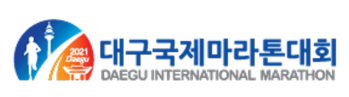

In [ ]:
# 1. 이상치에 해당하는 overview의 이미지
outlier_overview_image = cv2.imread(train.iloc[3030]['img_path'])
plt.imshow(cv2.cvtColor(outlier_overview_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
# 2. 대구국제마라톤을 검색해보고 overview를 채워넣기
train.loc[3030, 'overview'] = "대구국제마라톤대회는 대한민국의 대구에서 매년 4월에 열리는 마라톤 대회이다. 세계육상연맹이 10년 연속 '실버라벨'을 인정한 국제마라톤 대회이다."
train.iloc[3030]

id                                                    TRAIN_03030
img_path                            ./image/train/TRAIN_03030.jpg
overview        대구국제마라톤대회는 대한민국의 대구에서 매년 4월에 열리는 마라톤 대회이다. 세계육...
cat1                                                 인문(문화/예술/역사)
cat2                                                        공연/행사
cat3                                                         기타행사
overview_len                                                    7
Name: 3030, dtype: object

- (2) 한글외 문자제거

In [ ]:
train['overview'] = train['overview'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train['overview'].replace('',np.nan, inplace=True)
train.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


id              0
img_path        0
overview        0
cat1            0
cat2            0
cat3            0
overview_len    0
dtype: int64

In [ ]:
le = LabelEncoder()
train["target"] = le.fit_transform(train['cat3'].to_numpy())
#del train['overview_len']
train

,id,img_path,overview,cat1,cat2,cat3,overview_len,target
0,TRAIN_00000,./image/train/TRAIN_00000.jpg,소안항은 조용한 섬으로 인근해안이 청정해역으로 일찍이 김 양식을 해서 높은 소득을 ...,자연,자연관광지,항구/포구,217,120
1,TRAIN_00001,./image/train/TRAIN_00001.jpg,경기도 이천시 모가면에 있는 골프장으로 대중제 홀이다 회원제로 개장을 했다가 년 대...,레포츠,육상 레포츠,골프,244,8
2,TRAIN_00002,./image/train/TRAIN_00002.jpg,금오산성숯불갈비는 한우고기만을 전문적으로 취급하고 사용하는 부식 자재 또한 유기농법...,음식,음식점,한식,160,118
3,TRAIN_00003,./image/train/TRAIN_00003.jpg,철판 위에서 요리하는 안동찜닭을 맛볼 수 있는 곳이다 경상북도 안동시에 있는 한식 ...,음식,음식점,한식,67,118
4,TRAIN_00004,./image/train/TRAIN_00004.jpg,영업시간 대에 걸쳐 아귀만을 전문으로 취급하는 전통과 역사를 자랑하는 음식점이다,음식,음식점,한식,63,118
...,...,...,...,...,...,...,...,...
16981,TRAIN_16981,./image/train/TRAIN_16981.jpg,해발 에 자리한 식담겸 카페점문점이다곤드레밥과 감자전을 판매하고 있다,음식,음식점,한식,50,118
16982,TRAIN_16982,./image/train/TRAIN_16982.jpg,설악힐호텔은 동해고속도로 속초톨게이트에서 멀지 않은 관광로 변에 있다 속초의 대표 ...,숙박,숙박시설,모텔,471,31
16983,TRAIN_16983,./image/train/TRAIN_16983.jpg,충남 서산시 중심가에 위치한 줌모텔은 프라이버스가 보장되는 조용한 공간으로 가치가 ...,숙박,숙박시설,모텔,282,31
16984,TRAIN_16984,./image/train/TRAIN_16984.jpg,토토큰바위캠핑장은 경기도 가평지역 내에서도 청정지역으로 손꼽히는 지역으로 주변에 화...,레포츠,육상 레포츠,"야영장,오토캠핑장",158,73


# 형태소 분석기

In [ ]:
!pip install kiwipiepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 30.3 MB/s 
     |████████████████████████████████| 30.5 MB 1.3 MB/s 
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.14.0-py3-none-any.whl size=30560039 sha256=72d13bc63a5e7eea5d10ad3ac49219d158074e20b1e0ecf13e89f83ead87e9b6
  Stored in directory: /root/.cache/pip/wheels/97/36/50/1fc99e4a3ce636ed30739cc2cb333b36e6e3778f365f1adf77
Successfully built kiwipiepy-model


In [ ]:
from kiwipiepy import Kiwi

kiwi = Kiwi()
kiwi.prepare()

In [ ]:
lst = train["overview"].tolist()
gen = kiwi.analyze(lst)
train_overview = []

for tokens in tqdm(gen,total=len(lst)):
    token = [ token.form for token in tokens[0][0] if token.tag[0] == "NNG" or "VV" or "NNP" ]
    train_overview.append(" ".join(token))

lst = test["overview"].tolist()
gen = kiwi.analyze(lst)
test_overview = []
for tokens in tqdm(gen,total=len(lst)):
    token = [ token.form for token in tokens[0][0] if token.tag[0] == "NNG" or "VV" or "NNP" ]
    test_overview.append(" ".join(token))

  0%|          | 0/16986 [00:00<?, ?it/s]

  0%|          | 0/7280 [00:00<?, ?it/s]

# 사전모델

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 30.3 MB/s 
     |████████████████████████████████| 7.6 MB 56.5 MB/s 
     |████████████████████████████████| 163 kB 58.5 MB/s 


In [ ]:
# model_name = "klue/bert-base"
# from transformers import AutoTokenizer, AutoModel

# tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
model_name = "kykim/bert-kor-base"

from transformers import BertTokenizerFast, BertModel

tokenizer = BertTokenizerFast.from_pretrained(model_name)

Downloading:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/344k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/725 [00:00<?, ?B/s]

In [ ]:
train_overview = np.array(train_overview)
test_overview = np.array(test_overview)
target = train.target.to_numpy()

In [ ]:
token = tokenizer(train_overview[0], add_special_tokens=True,padding="max_length", truncation=True)
token

{'input_ids': [2, 5035, 8102, 8200, 5883, 17057, 7649, 1, 4971, 15564, 18416, 27218, 5921, 23379, 7677, 8151, 15564, 17153, 8018, 2482, 28747, 5887, 7649, 23917, 2949, 5883, 19576, 5887, 15288, 2260, 5941, 5879, 8271, 15721, 16812, 8137, 3828, 3238, 14650, 7649, 3110, 7670, 14823, 5617, 14240, 3290, 1, 28747, 8020, 3396, 5883, 4971, 16065, 3396, 5907, 23448, 7649, 1, 14686, 8017, 5887, 25115, 3685, 8100, 3125, 2260, 5941, 5879, 8271, 5929, 8576, 3463, 4971, 5907, 6035, 8217, 5883, 15721, 5907, 22937, 5895, 5887, 14624, 7554, 2260, 5941, 3052, 3406, 7649, 3110, 3547, 7653, 4971, 5617, 3052, 2103, 5222, 5641, 22122, 29151, 29321, 3408, 5907, 4964, 8393, 2102, 6019, 8052, 5590, 34607, 2260, 5941, 5879, 8271, 17922, 6035, 8063, 7557, 8082, 8031, 7557, 8371, 5921, 14391, 8038, 2260, 5941, 3110, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self ,tokenizer , x, y = None ): 
        self.tokenizer = tokenizer
        self.x = x
        self.y = y
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, idx): 
        item = {}
        item["x"] = self.__tokenizer(self.x[idx]) 
        if self.y is not None:
            item["y"] = torch.tensor(self.y[idx])
        return item
    def __tokenizer(self,text):
        inputs = self.tokenizer(text, add_special_tokens=True,padding="max_length", truncation=True)
        for k, v in inputs.items(): 
            inputs[k] = torch.LongTensor(v) 
        return inputs

In [ ]:
dt = MyDataset(tokenizer,train_overview,target)
dl = torch.utils.data.DataLoader(dt, batch_size=2,shuffle=False) 
batch = next(iter(dl))
batch

{'x': {'input_ids': tensor([[    2,  5035,  8102,  ...,     0,     0,     0],
         [    2, 16403, 22624,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}, 'y': tensor([120,   8])}

In [ ]:
model = BertModel.from_pretrained(model_name)

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
batch["x"].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
outputs = model(**batch["x"])
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [ ]:
model.config.hidden_size

768

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, model_name): 
        super().__init__()
        self.model = BertModel.from_pretrained(model_name)
        self.output_layer = torch.nn.Linear(self.model.config.hidden_size, 128)
    def forward(self, x):
        x = self.model(**x) 
        x = self.output_layer(x[1]) # globar pooling
        return x

In [ ]:
train.target.nunique()

128

In [ ]:
def train_loop(dataloader,model,loss_fn,optimizer,device):
    epoch_loss = 0 
    model.train() 
    for batch in tqdm(dataloader): 
        pred = model(batch["x"].to(device)) 
        loss = loss_fn(pred, batch["y"].to(device)) 
        
        optimizer.zero_grad() 
        loss.backward()  
        optimizer.step() 
        
        epoch_loss += loss.item() 

    epoch_loss /= len(dataloader) 

    return epoch_loss 

In [ ]:
@torch.no_grad() 
def test_loop(dataloader,model,loss_fn,device): 
    epoch_loss = 0
    model.eval() 

    
    pred_list = []
    softmax = torch.nn.Softmax(dim=1) 

    for batch in tqdm(dataloader):
        
        pred = model(batch["x"].to(device))
        if batch.get("y") is not None: 
            loss = loss_fn(pred, batch["y"].to(device))
            epoch_loss += loss.item()
        
        pred = softmax(pred)
        pred = pred.to("cpu").numpy() 
        pred_list.append(pred)

    epoch_loss /= len(dataloader)

    pred = np.concatenate(pred_list) 
    return epoch_loss , pred 

In [ ]:
n_splits = 5
batch_size = 8 
epochs = 100
loss_fn = torch.nn.CrossEntropyLoss() # 다중분류 손실객체

In [ ]:
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
cv = KFold(n_splits=n_splits,shuffle=True, random_state=SEED)

In [ ]:
is_holdout = False
seed_everything(SEED)
best_score_list = []
for i,(tri,vai) in enumerate(cv.split(train_overview)):
    # if i != 2:
    #     continue
    model = Net(model_name).to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=0.00003)

    train_dt = MyDataset(tokenizer,train_overview[tri],target[tri])
    valid_dt = MyDataset(tokenizer,train_overview[vai],target[vai])
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size,shuffle=False)

    best_score = 0
    patience = 0

    for epoch in range(epochs):
        
        train_loss = train_loop(train_dl, model, loss_fn,optimizer,device )
        valid_loss , pred = test_loop(valid_dl, model, loss_fn,device  )
        
        pred = np.argmax(pred, axis=1) 
        true = target[vai] 
        score = f1_score(true, pred , average="weighted")
        print(train_loss,valid_loss,score)
        patience += 1
        if best_score < score:
            patience = 0
            best_score = score
            torch.save(model.state_dict(),f"{DATA_PATH}model_{i}.pth")

        if patience == 2:
            break
    print(f"Fold ({i}), BEST F1: {best_score}")
    best_score_list.append(best_score)

    torch.cuda.empty_cache()

    if is_holdout:
        break

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/425 [00:00<?, ?it/s]

1.4710679867750516 0.8950591229252955 0.7526720600288936


  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/425 [00:00<?, ?it/s]

0.7259081819392368 0.7650861078982845 0.796818451330535


  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/425 [00:00<?, ?it/s]

0.4971798977739517 0.7263355765009628 0.8131498208634819


  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/425 [00:00<?, ?it/s]

0.3466683594376208 0.7595633879424456 0.8134048091246243


  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/425 [00:00<?, ?it/s]

0.2490825760708612 0.7763617469140274 0.8147474107770675


  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/425 [00:00<?, ?it/s]

0.1734919226777029 0.8575163516095456 0.8029771457531487


  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/425 [00:00<?, ?it/s]

- 0.6758478734792689
- 0.7559308455823053
- 0.7868188905667964
- 0.802353585145297
- 0.819720317777471
- 0.8281605404997975
- 0.8255226455881923
- 0.8217872686210416
- Fold (0), BEST F1: 0.8281605404997975

- 0.6789187653401642
- 0.7648935327807784
- 0.7877083397372897
- 0.8003873403145312
- 0.8111014890757857

In [ ]:
np.mean(best_score_list)

In [ ]:
is_holdout = False

In [ ]:
test_dt = MyDataset(tokenizer,test_overview)
test_dl = torch.utils.data.DataLoader(test_dt, batch_size=batch_size, shuffle=False)
pred_list = []

for i in range(n_splits):
    model = Net(model_name).to(device)
    state_dict = torch.load(f'{DATA_PATH}model_{i}.pth')
    model.load_state_dict(state_dict)

    _ , pred = test_loop(test_dl, model, loss_fn,device  )
    pred_list.append(pred)

    if is_holdout:
        break

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/455 [00:00<?, ?it/s]

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/455 [00:00<?, ?it/s]

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/455 [00:00<?, ?it/s]

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/455 [00:00<?, ?it/s]

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/455 [00:00<?, ?it/s]

In [ ]:
pred = np.mean(pred_list,axis=0) 
pred = np.argmax(pred, axis=1) 
pred

array([118, 118, 118, ...,  73,  31,  44])

In [ ]:
submit = pd.read_csv("sample_submission.csv")
submit["cat3"] = le.inverse_transform(pred)
submit

,id,cat3
0,TEST_00000,한식
1,TEST_00001,한식
2,TEST_00002,한식
3,TEST_00003,수련시설
4,TEST_00004,산
...,...,...
7275,TEST_07275,한식
7276,TEST_07276,공연장
7277,TEST_07277,"야영장,오토캠핑장"
7278,TEST_07278,모텔


In [ ]:
# submit.to_csv(f'{DATA_PATH}submit.csv', index=False)

In [ ]:
submit.to_csv('submit_Ensemble_kykim.csv', index=False)